In [98]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
import pandas as pd
import tarfile
import json
import tqdm

from scipy.stats import beta


# Prepare matplotlib
This just means generating a custom color palette


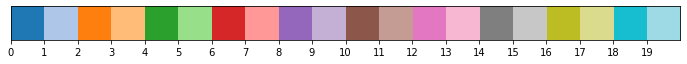

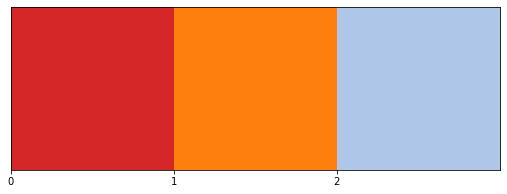

In [70]:
from matplotlib import colors

def plot_fig_label(ax, lab):
    ax.text(0, 1.1, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm
def view_colormap(cmap):
    """Plot a colormap"""
    if isinstance(cmap, str):
        cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])
    


    
view_colormap('tab20')

cm = makeCmap('tab20', [6, 2, 1])
view_colormap(cm)

# Prepare a class to parse the data

In [29]:
targets_df= pd.read_csv('../0_data/subset_targets.csv')
uniprots = pd.read_csv('uniprot_accessions.csv')
targets_df=targets_df.merge(uniprots, on=['chembl_id', 'pref_name']).drop(['year', 
                                                                           'canonical_smiles', 
                                                                           'lig_chemblid',
                                                                          'pchembl_value'],axis=1)


In [182]:
class pcv_load(object):

    def __init__(self, basedir):
        self.basedir = basedir
    def load_checkpoint(self):
        tar = tarfile.open('./'+self.basedir+'ligands.json.tar.gz')
        f = tar.extractfile('ligands.json')
        self.ligands = json.loads(f.read())

        self.targets = json.load(open('./'+self.basedir+'targets.json', 'r'))

        self.predictions = json.load(open('./'+self.basedir+'predictions.json', 'r'))
        
    def parse_predictions(self):
        df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'outcome', 'nnrank', 'prob'])
        count = 0 
        for pred in tqdm.tqdm_notebook(self.predictions.keys()):
            lig, targ = pred.split(':')

            #target_synonyms = pcv.targets[targ]['synonyms']
            tid = self.targets[targ]['tid']
            pref_name = self.targets[targ]['pref_name']
            accession = self.targets[targ]['accession']
        
            ligand_chemblid = self.ligands[lig]['chemblid']
    
    
            #check if there are any active or inactive assays at all:
            actives = self.ligands[lig]['actives']
            inactives = self.ligands[lig]['inactives']
    
            num_actives = sum([1 if _==accession else 0 for _ in actives.values()])
            num_inactives = sum([1 if _==accession else 0 for _ in inactives.values()])
    
            nn = self.predictions[pred]['nn']
            prob = float(self.predictions[pred]['prob'])
    
            if (num_actives+num_inactives) > 0:
                for key, value in actives.items():
                    if accession in value:
                        df.loc[count] = [tid, pref_name, ligand_chemblid, 'Active', nn, prob]
                        count+=1
                for key, value in inactives.items():
                    if accession in value:
                        df.loc[count] = [tid, pref_name, ligand_chemblid, 'Inactive', nn, prob]
                        count+=1
        self.df = df
        
    def save(self):
        #save all raw data:
        self.df.sort_values(by='pref_name').to_csv(self.basedir+'/results.csv')
        
    def pivot_df(self):
        #aggregate the multiple assays for each protein-ligand pair into an 'active', 'inactive', or 'equal' record. 

        piv = self.df.pivot_table(index=['pref_name','lig_chemblid', 'prob', 'nnrank'], 
               columns='outcome', 
               aggfunc='size', 
               fill_value=0)
        res = piv.reset_index()
        res['result'] = np.sign(res['Active'] - res['Inactive'])
        res['result'] = res['result'].apply(lambda x: {-1:'Inactive', 0:'Both', 1:'Active'}[x])
        result = res.drop('Active', axis=1).drop('Inactive', axis=1)
        result.reset_index(drop=True, inplace=True)#.head()
        self.result = result
        
    def count(self, rank):
        df_ = self.result[self.result['nnrank']>rank]
        pos = (df_['result']=='Active').sum()
        neg = (df_['result']=='Inactive').sum()
        return pos, neg
    
    def count_posi_and_nega(self):
        self.posi = np.zeros(150)
        self.nega = np.zeros(150)
        for i in range(1,151):
            pos, neg = self.count(i)
            self.posi[i-1]=pos
            self.nega[i-1]=neg
        self.tots = self.nega + self.posi

        

# Load up data and parse:

In [183]:
pcv_lightfm = pcv_load('processed_data/lightfm_warp/')
pcv_implicitbpr = pcv_load('./processed_data/implicit_bpr/')
pcv_labcorr = pcv_load('./processed_data/label_correlation/')
pcv_rf = pcv_load('./processed_data/random_forest/')
pcv_sea = pcv_load('./processed_data/sea/')

In [187]:
pcv_lightfm.load_checkpoint()
pcv_lightfm.parse_predictions()
pcv_lightfm.pivot_df()
pcv_lightfm.count_posi_and_nega()

pcv_implicitbpr.load_checkpoint()
pcv_implicitbpr.parse_predictions()
pcv_implicitbpr.pivot_df()
pcv_implicitbpr.count_posi_and_nega()


pcv_labcorr.load_checkpoint()
pcv_labcorr.parse_predictions()
pcv_labcorr.pivot_df()
pcv_labcorr.count_posi_and_nega()

pcv_rf.load_checkpoint()
pcv_rf.parse_predictions()
pcv_rf.pivot_df()
pcv_rf.count_posi_and_nega()

pcv_sea.load_checkpoint()
pcv_sea.parse_predictions()
pcv_sea.pivot_df()
pcv_sea.count_posi_and_nega()

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


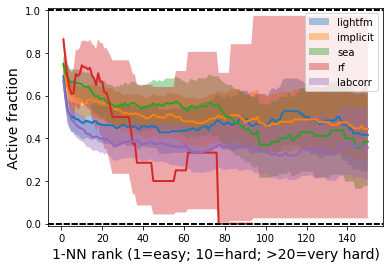

In [188]:
def plot_hit_fraction(pcv, ax, leg):
    fsize = 14
    rate = pcv.posi/ pcv.tots
    low = beta.ppf(0.025, pcv.posi+1, pcv.tots-pcv.posi+1)
    high =beta.ppf(0.975, pcv.posi+1, pcv.tots-pcv.posi+1)

    ax.fill_between(x=range(1,151),y1=low, y2=high,alpha=0.4, label=leg)
    ax.plot(range(1,151), rate, linewidth=2,)

    ax.set_ylabel('Active fraction',fontsize=fsize)
    ax.set_xlabel('1-NN rank (1=easy; 10=hard; >20=very hard)',fontsize=fsize)
    ax.set_ylim(bottom=-0.01,top=1.01)
    ax.axhline(0, linestyle='--', c='k')
    ax.axhline(1, linestyle='--', c='k')



fig, ax = plt.subplots()
plot_hit_fraction(pcv_lightfm, ax, 'lightfm')
plot_hit_fraction(pcv_implicitbpr, ax, 'implicit')
plot_hit_fraction(pcv_sea, ax, 'sea')
plot_hit_fraction(pcv_rf, ax, 'rf')
plot_hit_fraction(pcv_labcorr,ax, 'labcorr')
ax.legend()



In [196]:
def plot_proba(pcv, ax):
    fsize=13
    jit = np.random.random(len(pcv.result))-0.5
    jit /= 12
    jit += 1
    
    cax = ax.scatter(pcv.result['nnrank'].values*jit, 
            pcv.result['prob'].values.astype(float),
           c=pcv.result['result'].apply(lambda x: {'Active':1, 'Inactive':-1, 'Both':0}[x]),
           cmap = cm,
           alpha=0.7,
           edgecolor='k')
    ax.set_xscale('log')
    
    cbar = fig.colorbar(cax, ticks=[-0.66, 0, 0.66], ax=ax)
    cbar.ax.set_yticklabels(['Inactive', 'Both', 'Active'], fontsize=fsize) 

    ax.set_xlabel('log$_{10}}$(1-NN rank)', fontsize=fsize)
    ax.set_ylabel('Label correlation probability', fontsize=fsize)

    

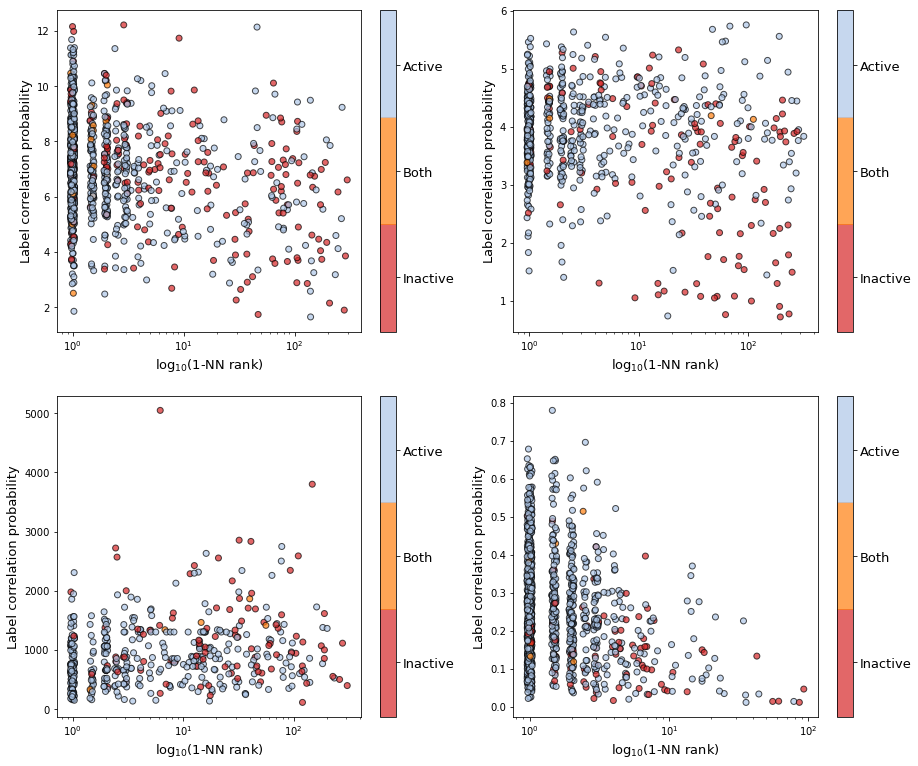

In [197]:
fig, ax = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(13)
plot_proba(pcv_lightfm, ax[0,0])
plot_proba(pcv_implicitbpr, ax[0,1])
plot_proba(pcv_sea, ax[1,0])
plot_proba(pcv_rf, ax[1,1])

# As altair:

## Proba vs score

In [218]:
def get_jitted_proba(pcv):
    jit = np.random.random(len(pcv.result))-0.5
    jit /= 12
    jit += 1
    
    return pcv.result['prob'].values.astype(float),pcv.result['nnrank'].values*jit, pcv.result['result']

res = {'Algorithm':[], 'Score':[], '1-NN rank':[], 'Result':[]}

scores, nnranks, result = get_jitted_proba(pcv_lightfm)
for j, k, l in zip(scores, nnranks, result):
    res['Algorithm'].append('LightFM-WARP')
    res['Score'].append(j)
    res['1-NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_implicitbpr)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Implicit-BPR')
    res['Score'].append(j)
    res['1-NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_sea)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('SEA')
    res['Score'].append(j)
    res['1-NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_rf)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Random Forest')
    res['Score'].append(j)
    res['1-NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_labcorr)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Label correlation')
    res['Score'].append(j)
    res['1-NN rank'].append(k)
    res['Result'].append(l)

In [219]:
d = pd.DataFrame(res)

In [220]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(d).mark_point().encode(
    y='Score:Q',
    x=alt.X('1-NN rank:Q'),# scale=alt.Scale(type='log'),),
    color='Result:N'
).properties(
    width=180,
    height=180
).facet(
   facet='Algorithm:N',
    columns=3
).resolve_scale(y='independent')


alt.FacetChart(...)

## Rate vs nnrank:

In [221]:
def get_hit_fraction(pcv):

    rate = pcv.posi/ pcv.tots
    low = beta.ppf(0.025, pcv.posi+1, pcv.tots-pcv.posi+1)
    high =beta.ppf(0.975, pcv.posi+1, pcv.tots-pcv.posi+1)

    return rate, low, high

res = {'Algorithm':[], 'Rate':[], 'Low':[], 'High':[], '1-NN rank':[]}

rate, low, high = get_hit_fraction(pcv_lightfm)
for j, k, l, nn in zip(rate, low, high, range(1,151)):
    res['Algorithm'].append('LightFM-WARP')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['1-NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_implicitbpr)
for j, k, l, nn in zip(rate, low, high, range(1,151)):
    res['Algorithm'].append('Implicit-BPR')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['1-NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_sea)
for j, k, l, nn in zip(rate, low, high, range(1,151)):
    res['Algorithm'].append('SEA')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['1-NN rank'].append(nn)

rate, low, high = get_hit_fraction(pcv_rf)
for j, k, l, nn in zip(rate, low, high, range(1,151)):
    res['Algorithm'].append('Random forest')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['1-NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_labcorr)
for j, k, l, nn in zip(rate, low, high, range(1,151)):
    res['Algorithm'].append('Label correlation')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['1-NN rank'].append(nn)


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [256]:
d = pd.DataFrame(res)

In [258]:
line = alt.Chart(d).mark_line().encode(
    x='1-NN rank',
    y=alt.Y('Rate', title='PubChem validation hit rate'),
    color=alt.Color('Algorithm')
)

band = line.mark_area(opacity=0.5).encode(
    x='1-NN rank',
    y=alt.Y('Low'),
    y2='High'
)

(band + line).properties(height=130, width=170).facet('Algorithm',columns=3).interactive()



alt.FacetChart(...)

In [261]:
d[d['1-NN rank']==40]

,Algorithm,Rate,Low,High,1-NN rank
39,LightFM-WARP,0.458333,0.362028,0.557918,40
189,Implicit-BPR,0.504854,0.409691,0.599661,40
339,SEA,0.544304,0.434674,0.649724,40
489,Random forest,0.285714,0.085233,0.650856,40
639,Label correlation,0.373984,0.293463,0.462296,40


In [265]:
from statsmodels.stats.proportion import multinomial_proportions_confint

idx = 39
hits = [pcv_implicitbpr.posi[idx], pcv_labcorr.posi[idx], pcv_lightfm.posi[idx],
       pcv_rf.posi[idx], pcv_sea.posi[idx]]
misses = [pcv_implicitbpr.nega[idx], pcv_labcorr.nega[idx], pcv_lightfm.nega[idx],
       pcv_rf.nega[idx], pcv_sea.nega[idx]]

In [330]:
n = 100000
confidence = list()


for idx in range(1,150):
    bpr = beta(pcv_implicitbpr.posi[idx]+1, pcv_implicitbpr.nega[idx]+1)
    rf = beta(pcv_rf.posi[idx]+1, pcv_rf.nega[idx]+1)
    
    draw1 = bpr.rvs(n)
    draw2 = rf.rvs(n)
    confidence.append((draw1 > draw2).sum()/len(draw1))

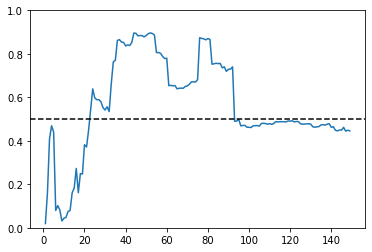

In [331]:
plt.plot(range(1,150), confidence)
plt.ylim(0,1)
plt.axhline(0.5, linestyle='--',c='k')

In [275]:
bpr = beta(hits[0]+1, misses[0]+1)
rf = beta(hits[-2]+1, misses[-2]+1)

In [311]:
n = 100000

draw1 = bpr.rvs(n)
draw2 = rf.rvs(n)
(draw1 > draw2).sum()/len(draw1)

0.85139

In [309]:
(draw1 > draw2).sum()/len(draw1)

0.8522

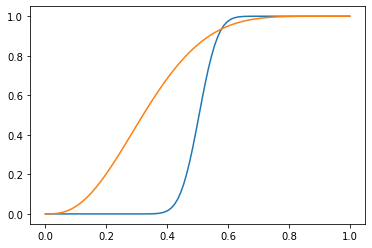

In [282]:
p = np.linspace(0,1,100)
plt.plot(p, bpr.cdf(p))
plt.plot(p, rf.cdf(p))

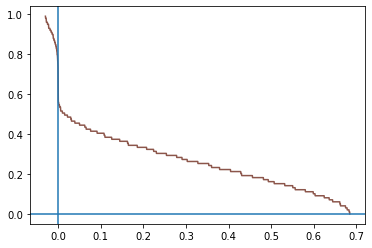

In [303]:
Z = (rf.cdf(p)  - bpr.cdf(p))[1:]

N = len(Z)
H,X1 = np.histogram( Z, bins = 3000, density=True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx


#print((1-F1)[X1[1:]>0.5][0])
plt.plot(X1[1:], 1-F1, c='C5')
plt.axvline(0)
plt.axhline(0)

In [ ]:

#plot one-tailed estimate:
Z = np.exp(tr['a'])
#Z = tr['a']
N = len(Z)
H,X1 = np.histogram( Z, bins = 3000, density=True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


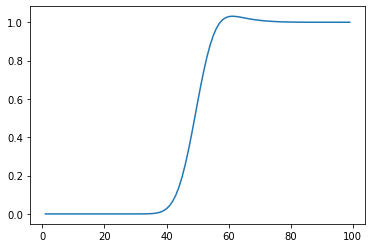

In [284]:
plt.plot(bpr.cdf(p) / rf.cdf(p))

In [269]:
ci_green = multinomial_proportions_confint(hits, alpha=0.05, method='sison-glaz')
ci_blue = multinomial_proportions_confint(misses, alpha=0.05, method='sison-glaz')


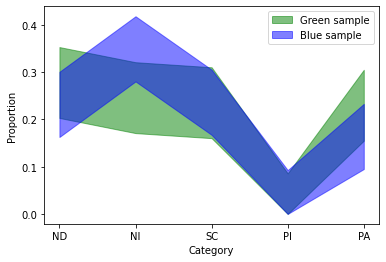

In [270]:
_=plt.fill_between(np.arange(5), ci_green[:,0], ci_green[:,1], alpha=0.5, label='Green sample', color='green')
_=plt.fill_between(np.arange(5), ci_blue[:,0], ci_blue[:,1], alpha=0.5, label='Blue sample', color='blue')
plt.ylabel('Proportion')
plt.xlabel('Category')
_=plt.xticks(np.arange(5),['ND', 'NI', 'SC',  'PI',  'PA'])
_=plt.legend()


In [252]:
d = pcv_implicitbpr.df['outcome'].apply(lambda x: {'Active':1, 'Inactive':-1, 'Both':0}[x])
probs = pcv_implicitbpr.df['prob']
# stride=15
# x = np.array(probs[probs.argsort()][::len(probs)//stride])
# digits = np.digitize(probs, x)
# nbin=len(x)
# for b in range(1,nbin):
#     mask = digits==b
#     pos=(d>0)[mask].sum()
#     neg=(d<0)[mask].sum()
#     low = beta.ppf(0.025, pos+1, neg+1)
#     high = beta.ppf(0.975, pos+1, neg+1)
#     plt.plot([ x[b], x[b]], [low,high],c='k')
#     plt.scatter([x[b]], [pos/(pos+neg)], edgecolor='k', facecolor='white', linewidth=2)
    
# plt.ylim(0,1)

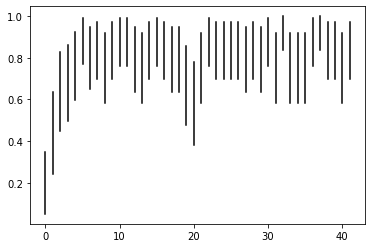

In [253]:
order = np.argsort(probs)
d_sorted = d[order].values
for count, item in enumerate(np.array_split(d_sorted, d_sorted.shape[0]//20)):
    numpos = (item>0).sum()
    numneg = (item<0).sum()
    low = beta.ppf(0.025, numpos+1, numneg+1)
    high = beta.ppf(0.975, numpos+1, numneg+1)
    plt.plot([count,count],[low,high],c='k')

In [1879]:
stride = 12
x = probs[probs.argsort()][::len(probs)//stride]
digits = np.digitize(probs,x)
nbin=len(x)
for b in range(1,nbin):
#for b in range(1,len(x[:-1])):
    mask = digits==b
    
    pos = ((d[0] - d[1])>0)[mask].sum()
    neg = ((d[0] - d[1])<0)[mask].sum()
    
    low = beta.ppf(0.025, pos+1, neg+1)
    high = beta.ppf(0.975, pos+1, neg+1)
    #print(pos/(pos+neg), low, high)
    
    plt.plot([ x[b], x[b]], [low, high], c='k')
    
    plt.scatter([x[b]], [pos/(pos+neg)],edgecolor = 'k', facecolor='white', linewidth=2)
    
plt.ylim(0,1)
plt.xlabel('Predicted probability')
plt.ylabel('Hit rate')

### 

# Plotting target types:

In [1859]:
import altair as alt

def parse_groups(group):
    inactive = group['outcome'].str.contains('Inactive').sum()
    active = group['outcome'].str.contains('Active').sum()
    if (active - inactive) > 0:
        return 'Active'
    if (active - inactive) < 0:
        return 'Inactive'
    else:
        return 'Both'

collapse the assay data into per-ligand-target-pair results (i.e. `active`, `inactive`, `equal`).

Here also have the opportunity to select a protein family classification. 


In [1860]:
def parse_data(df, classification, lim=None):
    if lim is not None:
        df = df.groupby('pref_name').filter(lambda x : len(x)>lim)

    filtered_df = df.merge(target_types, on='pref_name')
    out = filtered_df[filtered_df['l1'].isin(classification)].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

    out_df= pd.DataFrame(out).reset_index().drop('lig_chemblid',axis=1)

    out_df.columns=['pref_name', 'activity']
    return out_df
 
    

#Mask 1-NN solutions:
#out = df[df['nnrank']>0].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

types = filtered_df.l1.unique()
t = types[4]
print(t)

parse_data(df, [types[0]])


Membrane receptor


,pref_name,activity
0,Vascular endothelial growth factor receptor 2,Inactive
1,Dual specificity protein kinase CLK2,Inactive
2,Dual specificity protein kinase CLK4,Inactive
3,Fibroblast growth factor receptor 3,Inactive
4,Mitogen-activated protein kinase kinase kinase...,Inactive
...,...,...
256,c-Jun N-terminal kinase 1,Inactive
257,Fibroblast growth factor receptor 1,Inactive
258,Tyrosine-protein kinase JAK2,Inactive
259,Vascular endothelial growth factor receptor 2,Active


In [1862]:



def make_altair_long(df):
    ch = alt.Chart(df).mark_bar()

    ch = ch.encode(
        y = alt.Y('pref_name', sort='-x', title='Count'),
        x = alt.X('count()', title='Count'),
        color=alt.Color('activity'),
        order=alt.Order('activity', sort='ascending'),
        tooltip=['count()',]).properties(height=550,width=350).configure_axisY(
        titleFontSize=13,
            ).configure_axisX(
            titleFontSize=13
            ).configure_axisBottom(labelAngle=-35).configure_header(
                titleFontSize=40, 
                labelFontSize=40
            ).configure_axisY(
                titleAngle=0,
                titleAlign="left",
                titleY=-10,
                titleX=-20,
                titleFontSize=16,
            ).configure_legend(orient='bottom',labelFontSize=22)
    
    return ch



#make_altair_long(parse_data(df, [types[0]], 0))
make_altair_long(parse_data(df, types[1:], 0))

alt.Chart(...)

In [1866]:
def make_altair_wide(df, h=200, w=650):
    ch = alt.Chart(df).mark_bar()

    ch = ch.encode(
        x = alt.X('pref_name', sort='-y', title='Target preferred name'),
        y = alt.Y('count()'),
        color=alt.Color('activity'),
        order=alt.Order('activity', sort='ascending'),
    ).properties(height=h,width=w).configure_axisX(labelAngle=40)
    return ch

ch1 = make_altair_wide(parse_data(df, [types[0]], 5))
ch2 = make_altair_wide(parse_data(df, [types[4]], 0), h=150, w=400)
ch3 = make_altair_wide(parse_data(df, types, 10), h=200, w=750)


In [1867]:
ch1

alt.Chart(...)

In [1868]:
ch2

alt.Chart(...)

In [1420]:
ch2.save('./figures/receptors'

alt.Chart(...)

In [1423]:
ch3.save('./figures/all_target_classes.html')

In [991]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>2)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=500,width=300)

# ch.configure_axisY(
# titleFontSize=13,
# ).configure_axisX(
# titleFontSize=13
# ).configure_axisBottom(labelAngle=-35).configure_header(
#     titleFontSize=40, 
#     labelFontSize=40
# ).configure_axisY(
#     titleAngle=0,
#     titleAlign="left",
#     titleY=-10,
#     titleX=-20,
#     titleFontSize=16,
# ).configure_legend(orient='bottom',labelFontSize=22)

ch

alt.Chart(...)

In [1350]:
ch = alt.Chart(out_df).mark_bar()

ch = ch.encode(
    x = alt.X('pref_name', sort='-y', title='Target preferred name'),
    y = alt.Y('count()'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=200,width=750).configure_axisX(labelAngle=40)
ch



alt.Chart(...)

# Getting target classes:

In [894]:
target_types = pd.read_csv('target_classes.csv')

In [895]:
target_types

,chembl_id,l1,l2,l3,pref_name
0,CHEMBL3568,Enzyme,NaN,NaN,"Nitric-oxide synthase, brain"
1,CHEMBL2963,Enzyme,Protease,Metallo protease,Matrix metalloproteinase 15
2,CHEMBL2227,Ion channel,Other ion channel,Pore-forming toxins (proteins and peptides),Proenkephalin B
3,CHEMBL5208,Transporter,Electrochemical transporter,SLC superfamily of solute carriers,GABA transporter 3
4,CHEMBL3338,Enzyme,NaN,NaN,Squalene synthetase
...,...,...,...,...,...
3148,CHEMBL3989381,Unclassified protein,NaN,NaN,Hepcidin
3149,CHEMBL3989382,Unclassified protein,NaN,NaN,Macrophage colony-stimulating factor 1
3150,CHEMBL3989383,Unclassified protein,NaN,NaN,Tumor necrosis factor receptor superfamily mem...
3151,CHEMBL3989384,Unclassified protein,NaN,NaN,Cadherin-3


In [896]:
df.merge(target_types, on='pref_name')

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank,chembl_id,l1,l2,l3
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5,CHEMBL261,Enzyme,Lyase,NaN
1,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215276,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
3,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,47713,Active,inhibition of human carbonic anhydrase i cai,2.0,CHEMBL261,Enzyme,Lyase,NaN
4,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,50367,Active,inhibitory activity against human carbonic anh...,2.0,CHEMBL261,Enzyme,Lyase,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2105,CHEMBL1914,Butyrylcholinesterase,CHEMBL3604192,1240923,Active,inhibition of equine serum bche using atc iodi...,1.0,CHEMBL1914,Enzyme,Hydrolase,NaN
2106,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2107,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2108,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344881,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase


In [1456]:
from chembl_webresource_client.new_client import new_client 
target = new_client.target
tid = 'CHEMBL204'
res = target.filter(target_chembl_id=tid)
res

[{'cross_references': [{'xref_id': 'P00734', 'xref_name': None, 'xref_src': 'canSAR-Target'}, {'xref_id': 'Thrombin', 'xref_name': None, 'xref_src': 'Wikipedia'}], 'organism': 'Homo sapiens', 'pref_name': 'Thrombin', 'species_group_flag': False, 'target_chembl_id': 'CHEMBL204', 'target_components': [{'accession': 'P00734', 'component_description': 'Prothrombin', 'component_id': 92, 'component_type': 'PROTEIN', 'relationship': 'SINGLE PROTEIN', 'target_component_synonyms': [{'component_synonym': '3.4.21.5', 'syn_type': 'EC_NUMBER'}, {'component_synonym': 'Activation peptide fragment 1', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Activation peptide fragment 2', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Coagulation factor II', 'syn_type': 'UNIPROT'}, {'component_synonym': 'F2', 'syn_type': 'GENE_SYMBOL'}, {'component_synonym': 'Prothrombin', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Thrombin heavy chain', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Thrombin light chain', 